## Step3

### This notebook performs the following (same format for all sparse networks):
- 
- Reads matchup data file
- Calculates metrics
- Plots TS
- Writes metrics to main output file



In [1]:
import os
from pathlib import Path
import requests
# import json
# from osgeo import gdal,osr,ogr
import datetime
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# from matplotlib.dates import DateFormatter
# import matplotlib.path as mpltPath

from utilsCalVal import EASEconvert
import setParams as p


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
soilscapePath      = p.soilscapePath
soilscapeMeta      = p.soilscapeMeta
soilscapeNode      = p.soilscapeNode
trackFrameDb       = p.trackFrameDb 
anciStatic         = p.anciStatic

# Use which depth sensors?
allDepths     = [5,10,20,30]
targetDepth   = 0 #index of which depth to use
startDate     = p.startDate
endDate       = p.endDate


In [ ]:
#check files and make initial directory
Path(soilscapePath).mkdir(parents=True, exist_ok=True) #make soilscape directory if does not already exist
if not(os.path.isfile(soilscapeMeta)):
    print('Error: need metadata file  '+soilscapeMeta+' with SiteName,State,Country,Latitude,Longitude,Elevation[m],TimeZone,n-Devices,n-Sensors,location_id,startDate,endDate')
if not(os.path.isfile(soilscapeNode)):
    print('Error: need metadata file '+soilscapeNode+' with siteName,	siteIDNode,	longitude,	latitude')

if not(os.path.isfile(trackFrameDb)):
    print('Error - must download Track Frame database in order to match sites with NISAR frames, was at (restricted) https://drive.google.com/file/d/1_KbpgUGiYriUO18Rq7zKrTuXGAQl-Ksw/view?usp=sharing')
if not(os.path.isfile(anciStatic)):
    print('Error - need ancillary data file to assess land cover, etc.')  

## Read locations of overall soilscape sites

In [ ]:
sitesDF      = pd.read_csv(soilscapeMeta,index_col=None)
nsites       = len(sitesDF)

siteIDs      = sitesDF['location_id']
siteEndDates = sitesDF['endDate']
badid=[]
for i in range(nsites):
    if siteEndDates[i] !=0:
        badid.append(i)
        print('Site '+sitesDF['SiteName'][i]+' appears to have no current data')

sitesDF=sitesDF.drop(badid)

0
20241014
Site Riverhead appears to have no current data
0
0
0
20250226
Site CO-Z1 appears to have no current data
20240629
Site CO-Z4 appears to have no current data
0
0
0
[1, 5, 6]
10 7


## Read locations of soilscape nodes, convert to EASEGRID


In [ ]:
sitesDF    = pd.read_csv(soilscapeNode,sep='\t',index_col=None)
nsites     = len(sitesDF)
ezrowcol   = np.zeros((nsites,2),dtype=int)

for i in range(nsites):
    lon=sitesDF['longitude'][i]
    lat=sitesDF['latitude'][i]
    ezc,ezr   = EASEconvert(lon,lat,1)
    ezrowcol[i,0] = np.ceil(ezr-0.5)
    ezrowcol[i,1] = np.ceil(ezc-0.5)  
      
sitesDF['ezr']=ezrowcol[:,0]
sitesDF['ezc']=ezrowcol[:,1]

#unique row/cols, plus indices from each station to unique row/col, and count of stations within each unique row/col
uniqueEZ,EZindices,EZcount = np.unique(ezrowcol,axis=0,return_inverse=True, return_counts=True)
nez = np.shape(uniqueEZ)[0]


In [ ]:
#read track/frame database
tfdb      = gpd.read_file(trackFrameDb,layer='tfdb')

In [ ]:
#Open landcover, crop data (200mEASEGRID) and some dem info (1kmEASEGRID)
f         = h5py.File(anciStatic,'r')
d         = f['/landCover200m']
dc        = f['/cropmap200m']
ddem      = f['/dem1km'] #std deviation of heights within 1km cell, in meters
del f

In [42]:
for i in range(nez):
    dirName='r'+str(uniqueEZ[i,0])+'c'+str(uniqueEZ[i,1])
    # Make a directory for each site 
    Path(soilscapePath+dirName).mkdir(parents=True, exist_ok=True)

In [ ]:
#saving most of the values we eventually put in a list of dictionaries as individual lists, for ease in plotting below.
sites=[]
"https://soilscape.usc.edu/?csv_download_moisture=1&csv_download_moisture_site_id=26&valid_only=1&start_date=2025-02-04&end_date=2025-03-05"

for i in range(nez):
    ezr = uniqueEZ[i,0]
    ezc = uniqueEZ[i,1]
    dirName='r'+str(ezr)+'c'+str(ezc)
    # Make a directory for each site 
    Path(soilscapePath+dirName).mkdir(parents=True, exist_ok=True)

    lon,lat = EASEconvert(ezc+0.5,ezr+0.5,2)        #center of EASEGRID cell


    #search track frame database
    tfdb0     = tfdb.iloc[tfdb.sindex.query(shapely.Point(lon,lat), predicate="intersects")]
    tracks    = tfdb0['track'].values.tolist()
    frames    = tfdb0['frame'].values.tolist()
    tfNames   = []
    for j in range(len(frames)):
            tfName='T'+str(tracks[j])+'F'+str(frames[j])
            tfNames.append(tfName)
           
    lulc      = int(d[ezr,ezc])
    crop      = int(dc[ezr,ezc])
    dem       = float(ddem[np.floor(ezr/5).astype('int'),np.floor(ezc/5).astype('int')])

    #for now only save crop info if cropland
    if lulc!=4:
        crop=255

    tmpdct={'siteCode':dirName,
            'lat':lat,
            'lon':lon,
            'EASEGridRowIndex':ezr,
            'EASEGridColIndex':ezc,
            'lulc':lulc,
            'dem':dem,
            'crop':crop,
            'tracks':tracks,
            'frames':frames,
            'tfNames':tfNames,
            'framecount':len(frames)}
    sites.append(tmpdct)  

    



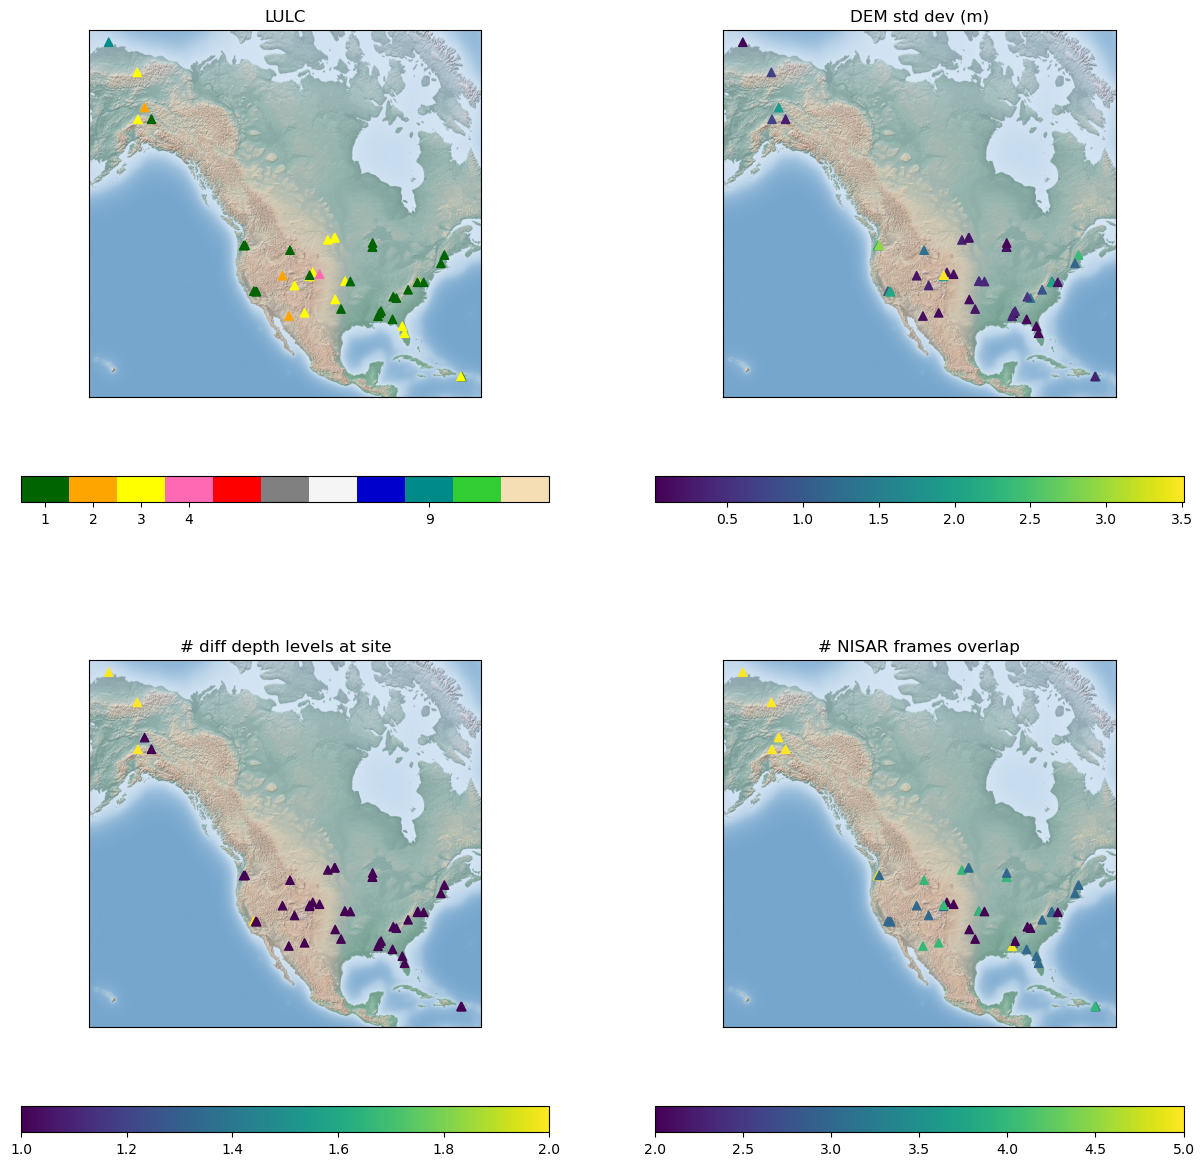

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(15,15))
#lulc
m = Basemap(projection='merc',llcrnrlat=min(lats)-5,urcrnrlat=max(lats)+1,llcrnrlon=min(lons)-5,urcrnrlon=max(lons)+5,lat_ts=35,resolution=None,ax=axes[0,0])
m.shadedrelief()
cmap=matplotlib.colors.ListedColormap(('darkgreen','orange','yellow','hotpink','red','gray','whitesmoke','mediumblue','darkcyan','limegreen','wheat'))
cb=m.scatter(lons,lats,c=lulcs,marker='^',vmin=0.5,vmax=11.5,cmap=cmap,latlon=True)
axes[0,0].set_title('LULC')
plt.colorbar(cb,ax=axes[0,0],ticks=np.unique(lulcs),orientation='horizontal')

#dem std. deviation within 1km grid cell
m = Basemap(projection='merc',llcrnrlat=min(lats)-5,urcrnrlat=max(lats)+1,llcrnrlon=min(lons)-5,urcrnrlon=max(lons)+5,lat_ts=35,resolution=None,ax=axes[0,1])
m.shadedrelief()
c=m.scatter(lons,lats,c=dems,marker='^',latlon=True)
axes[0,1].set_title('DEM std dev (m)')
plt.colorbar(c,ax=axes[0,1],orientation='horizontal')

#dem std. deviation within 1km grid cell
m = Basemap(projection='merc',llcrnrlat=min(lats)-5,urcrnrlat=max(lats)+1,llcrnrlon=min(lons)-5,urcrnrlon=max(lons)+5,lat_ts=35,resolution=None,ax=axes[1,0])
m.shadedrelief()
c=m.scatter(lons,lats,c=vrange,marker='^',latlon=True)
axes[1,0].set_title('# diff depth levels at site')
plt.colorbar(c,ax=axes[1,0],orientation='horizontal')

#number of frames covering each site
m = Basemap(projection='merc',llcrnrlat=min(lats)-5,urcrnrlat=max(lats)+1,llcrnrlon=min(lons)-5,urcrnrlon=max(lons)+5,lat_ts=35,resolution=None,ax=axes[1,1])
m.shadedrelief()
c=m.scatter(lons,lats,c=framecount,vmax=5,marker='^',latlon=True)
axes[1,1].set_title('# NISAR frames overlap')
plt.colorbar(c,ax=axes[1,1],orientation='horizontal')

plt.show()


### EASE row/col test

Next cell does same analysis as above, but explicitly checks to ensure that each pt of the five associated with each site is in the same EASEGRID2 cell as the others.

### Output csv

In [ ]:
sitePages = ['https://www.soilscapescience.org/field-sites/'+s.lower() for s in siteCodes]
sitesCSV = pd.DataFrame(
    {'siteCode': siteCodes,
     'Latitude': lats,
     'Longitude': lons,
     'EASEGridRowIndex': ezrs,
     'EASEGridColumnIndex': ezcs,
     'lulc': lulcs,
     'crop': crops,
     'demstd': dems,
     'TFcount':framecount,
     'web':sitePages
    })
sitesCSV.to_csv(soilscapePath+'soilscapeSites.csv',index=False)